In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
from skbio.stats.composition import ilr
from skbio.stats.composition import clr
from skbio.stats.composition import multiplicative_replacement
import seaborn as sns
from matplotlib import rcParams
from tqdm import tqdm

sns.set()
sns.set(font_scale=1.5)

## Import Feature Count Cohort Dataframes

In [2]:
japanese_allStrains_FeatureDF = pd.read_csv('./Files/Dataframes/Functional/FeatureCounts/Filled_japanese_PFam.csv')
japanese_allStrains_FeatureDF.set_index("SampleName", inplace=True)
japanese_allStrains_FeatureDF['Cohort'] = 'Healthy'

CRC_allStrains_FeatureDF = pd.read_csv('./Files/Dataframes/Functional/FeatureCounts/Filled_crc_PFam.csv')
CRC_allStrains_FeatureDF.set_index("SampleName", inplace=True)
CRC_allStrains_FeatureDF['Cohort'] = 'CRC'

In [3]:
#Concat all the nonNormalized Dataframes together to make 1 large dataframe (This contains Cohort)
allCohorts_allStrains_FeatureDF = pd.concat([japanese_allStrains_FeatureDF,CRC_allStrains_FeatureDF])

#Normalize DataFrame
allCohorts_allStrains_FeatureDF2 = allCohorts_allStrains_FeatureDF.drop(columns=['Cohort']).copy()
allCohorts_allStrains_FeatureDF_Normalized = allCohorts_allStrains_FeatureDF2.div(allCohorts_allStrains_FeatureDF2.sum(axis=1), axis=0).copy()            

## Perform CLR Transformation

In [4]:
def filterNoise(df):
    df3 = df.copy()
    
    # Quickly check if the entire column is bad
    lowMax = []
    for column in df3.columns:
        if df3[column].max() < 0.00001:
            lowMax.append(column)
    #Drop bad columns
    df4 = df3.drop(columns=lowMax).copy()
    
    #Create new dataframe and check noise levels
    thresh=0.00001
    df5 = df4.apply(lambda x: x.where(x > thresh, 0), axis=0).copy()
                
    return(df5)

In [5]:
filteredALLPFAM = allCohorts_allStrains_FeatureDF_Normalized.copy()
FilteredPFAMDF = filterNoise(filteredALLPFAM)

In [6]:
FilteredPFAMDF.head()
FilteredPFAMDF2 = FilteredPFAMDF.copy()
CLRallCohorts_FilteredPFAM = pd.DataFrame(columns=FilteredPFAMDF2.columns, index=FilteredPFAMDF2.index)

In [8]:
## Add a pseudocount to 0.0 value organisms in order to perform ILR transformations on dataframes (NORMALIZED)
from skbio.stats.composition import multiplicative_replacement
from skbio.stats.composition import clr


#All strains
allCohorts_allStrains_FeatureDF_Normalized.fillna(0.0, inplace=True)
clr_allCohorts_allStrains_FeatureDF_Normalized = pd.DataFrame(columns=allCohorts_allStrains_FeatureDF_Normalized.columns, index=allCohorts_allStrains_FeatureDF_Normalized.index)

In [9]:
for row in tqdm(CLRallCohorts_FilteredPFAM.index):
    CLRallCohorts_FilteredPFAM.loc[row] = clr(np.array(FilteredPFAMDF2.loc[row].replace(0.0, 1e-10)))

100%|██████████| 252/252 [00:33<00:00,  7.17it/s]


In [10]:
#ALL Strains
for row in tqdm(clr_allCohorts_allStrains_FeatureDF_Normalized.index):
    clr_allCohorts_allStrains_FeatureDF_Normalized.loc[row] = clr(np.array(allCohorts_allStrains_FeatureDF_Normalized.loc[row].replace(0.0, 1e-10)))

100%|██████████| 252/252 [01:01<00:00,  3.90it/s]


In [11]:
CLRallCohorts_FilteredPFAM['Cohort'] = allCohorts_allStrains_FeatureDF['Cohort'].copy()
clr_allCohorts_allStrains_FeatureDF_Normalized['Cohort'] = allCohorts_allStrains_FeatureDF['Cohort'].copy()

## Run PCA

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("SampleName",axis=1).copy()
    pcaDF3 = pcaDF2.drop("Cohort", axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={'Healthy':'gold', 'CRC':'grey'}

    fig = plt.figure(figsize = (11.7,8.27))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis ('+title+')')

    targets = ['Healthy','CRC']
    colors = ['gold','grey']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cohort'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets, bbox_to_anchor=(0.99, 0.97), loc=1, borderaxespad=0, title='Group', prop={'size': 14}, facecolor='white')
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.set(font_scale=1.3)
    #plt.savefig("./Files/"+filename+".png", bbox_inches='tight', dpi=300)
    plt.show()

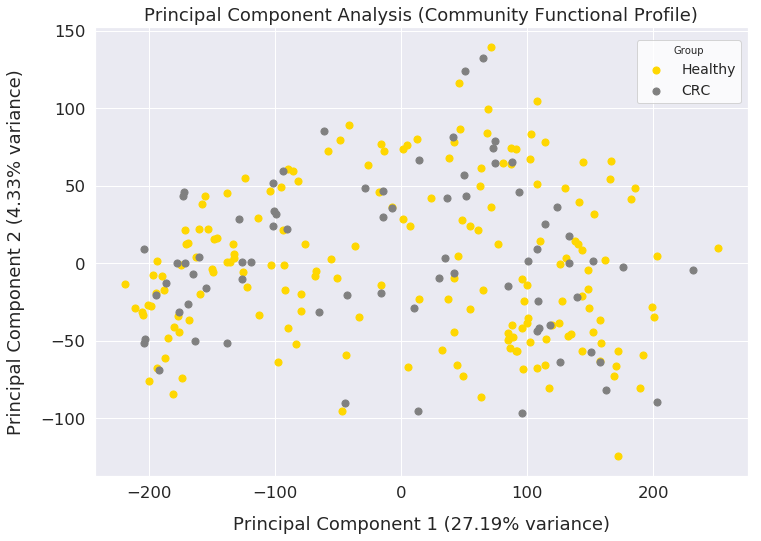

In [13]:
runPCA(clr_allCohorts_allStrains_FeatureDF_Normalized, 'allCohorts_clr_Pfam_FeatureCounts', 'Community Functional Profile')

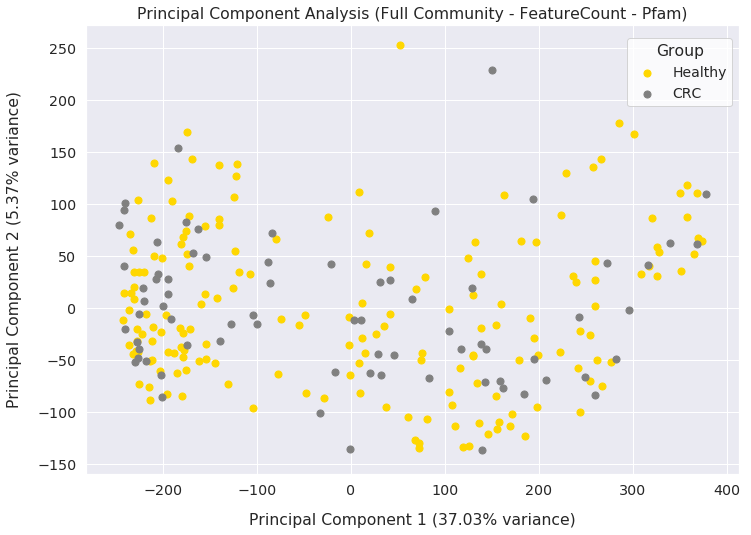

In [14]:
runPCA(CLRallCohorts_FilteredPFAM, 'allCohorts_clr_Pfam_FeatureCountsFILTERED', 'Full Community - FeatureCount - Pfam')